In [1]:
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Plots
using ProgressMeter
using BenchmarkTools

The perturbative expansion code supports symbolic calculation. Simply use one of the many symbolic packages in Julia and set the various parameters of interest to symbolic values instead of numeric ones. Here we show an example of a typical purification circuit that uses various computer algebra system available in Julia.

The circuit we will study is:

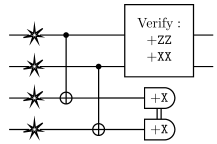

In [2]:
good_bell_state = S"XX
                    ZZ"
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 0.1 # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v] # Drawing the circuit out can be a bit slow as it uses LaTeX

## If you want to use `Symbolics`

In [3]:
using Symbolics
@variables e
unity = one(e);

In [4]:
good_bell_state = S"XX
                    ZZ"
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{Symbol, Num} with 3 entries:
  :undetected_failure => 6e*((1 - 3e)^3)
  :detected_failure   => 4e*((1 - 3e)^3)
  :true_success       => (1 - 3e)^4 + 2e*((1 - 3e)^3)

In [5]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 4195 samples with 1 evaluation.
 Range (min … max):  966.676 μs … 18.612 ms  ┊ GC (min … max): 0.00% … 87.34%
 Time  (median):       1.041 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.181 ms ±  1.051 ms  ┊ GC (mean ± σ):  5.57% ±  6.00%

  ▆█▇▇▆▅▄▃▃▃▃▂▁▁ ▁                                             ▂
  █████████████████▆▆▇▆▅▄▆▅▅▅▅▅▄▅▄▆▆▇▇▇▄▆▆▆▇▆▅▆▄▄▄▄▃▄▄▄▄▃▄▁▆▆▅ █
  967 μs        Histogram: log(frequency) by time      2.55 ms <

 Memory estimate: 405.56 KiB, allocs estimate: 9464.

In [6]:
# How to evaluate numerically
substitute(pe_symbolic[:true_success], Dict(e=>0.1))

0.3086999999999999

## If you want to use `AbstractAlgebra`

In [7]:
using AbstractAlgebra # Consider using Nemo.jl which can be much faster while having the same interfaces
R, (e,) = PolynomialRing(RealField, ["e"])
unity = R(1);

In [8]:
good_bell_state = S"XX
                    ZZ"
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{Symbol, AbstractAlgebra.Generic.MPoly{BigFloat}} with 3 entries:
  :undetected_failure => -162.0*e^4 + 162.0*e^3 - 54.0*e^2 + 6.0*e
  :detected_failure   => -108.0*e^4 + 108.0*e^3 - 36.0*e^2 + 4.0*e
  :true_success       => 27.0*e^4 - 54.0*e^3 + 36.0*e^2 - 10.0*e + 1

In [9]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 6432 samples with 1 evaluation.
 Range (min … max):  642.136 μs … 20.181 ms  ┊ GC (min … max):  0.00% … 94.43%
 Time  (median):     672.428 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   770.157 μs ±  1.155 ms  ┊ GC (mean ± σ):  10.29% ±  6.58%

   █▄▁                                                          
  ████▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▂▁▁▂▂▂▂▁▁▂▂▁▁▁▂▂▁▂▁▁▁▁▂▂▂ ▃
  642 μs          Histogram: frequency by time         1.32 ms <

 Memory estimate: 450.52 KiB, allocs estimate: 9012.

In [10]:
# How to evaluate numerically
pe_symbolic[:true_success](0.1)

0.30870000000000000282655843175660947963478974997997283935546875

## If you want to use `SymPy`

In [11]:
using SymPy
e = Sym("e")
unity = Sym(1);

In [12]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)
initial_state = good_bell_state⊗good_bell_state

g1 = SparseGate(CNOT, [1,3]) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = SparseGate(CNOT, [2,4]) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([X,X],[3,4]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{Symbol, Sym} with 3 entries:
  :undetected_failure => 6.0*e*(1 - 3*e)^3
  :detected_failure   => 4.0*e*(1 - 3*e)^3
  :true_success       => 2.0*e*(1 - 3*e)^3 + 1.0*(1 - 3*e)^4

In [13]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 998 samples with 1 evaluation.
 Range (min … max):  4.222 ms … 110.923 ms  ┊ GC (min … max): 0.00% … 64.66%
 Time  (median):     4.479 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.992 ms ±   5.621 ms  ┊ GC (mean ± σ):  4.00% ±  3.53%

  ▅██▆▄▂                                                       
  ████████▇▆██▇▆▅▁▅▁▁▁▁▁▅▄▅▁▅▄▄▁▄▁▁▁▁▁▁▄▁▁▁▁▄▁▁▁▄▁▁▄▁▁▁▁▁▄▁▁▄ █
  4.22 ms      Histogram: log(frequency) by time      10.6 ms <

 Memory estimate: 311.05 KiB, allocs estimate: 7359.

In [14]:
# How to evaluate numerically
pe_symbolic[:true_success].subs(e,0.1)

0.308700000000000

## Comparison to numeric result

In [15]:
true_success_symbolic = pe_symbolic[:true_success]

               3                4
2.0⋅e⋅(1 - 3⋅e)  + 1.0⋅(1 - 3⋅e) 

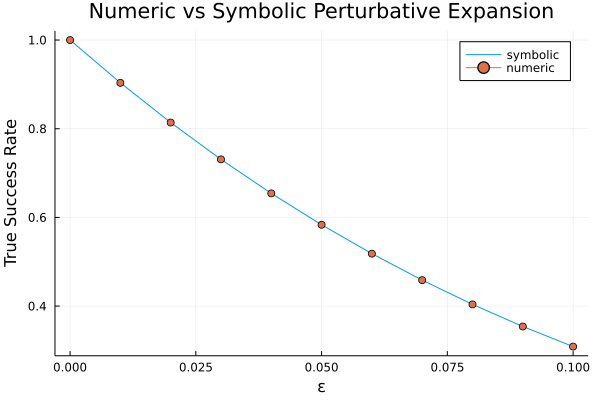

In [16]:
es_num = 0:0.01:0.1
symbolic_evaluations = [Float64(true_success_symbolic.subs(e,e_num)) for e_num in es_num]

numeric_evaluations = []
for epsilon in es_num
    n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))
    circuit = [n,g1,g2,m,v]
    pe_symbolic = petrajectories(initial_state, circuit)
    push!(numeric_evaluations, pe_symbolic[:true_success])
end

plot(es_num, symbolic_evaluations, label="symbolic")
plot!(es_num, numeric_evaluations, line=false, marker=true, label="numeric")
plot!(xlabel="ε", ylabel="True Success Rate", title="Numeric vs Symbolic Perturbative Expansion")

## Reproducibility information

In [17]:
versioninfo()
using Pkg
Pkg.status("QuantumClifford")
Pkg.status("Symbolics")
Pkg.status("AbstractAlgebra")
Pkg.status("SymPy")

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: AMD Ryzen 7 1700 Eight-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, znver1)
      Status `~/Documents/ScratchSpace/clifford/Project.toml`
  [0525e862] QuantumClifford v0.3.0 `QuantumClifford`
      Status `~/Documents/ScratchSpace/clifford/Project.toml`
  [0c5d862f] Symbolics v4.2.0
      Status `~/Documents/ScratchSpace/clifford/Project.toml`
  [c3fe647b] AbstractAlgebra v0.23.0
      Status `~/Documents/ScratchSpace/clifford/Project.toml`
  [24249f21] SymPy v1.1.2
